ERROR 1: PROJ: proj_create_from_database: Open of /home/jomueller/micromamba/envs/mamba_josh/share/proj failed


(1221, 3662) (1221, 3662)


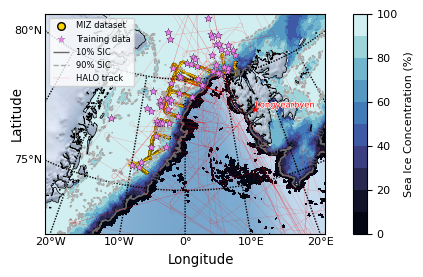

In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

SIC = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_unified_data/amsr_modis_sic.nc')
ds = xr.open_dataset('../../data/ar/HALO-AC3_HALO_VELOX_segmentation_statistics_with_sea_ice_edge_distance.nc')
ds_training = xr.open_dataset('../../data/training.nc')

# projection center point
lon0 = 0
lat0 = 78


train_lat = ds_training.lat.values
train_lon = ds_training.lon.values


plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(1, 1, figsize=(4.15, 4.15))

m = Basemap(projection='stere', resolution='h',
        lat_0=lat0, lon_0=lon0,  lat_ts=lat0, width=1400000, height=1100000, ax=ax)

m.drawmeridians(np.arange(0, 360, 10), labels=[0,0,0,1])  # left, right, top, bottom
m.drawparallels(np.arange(0, 90, 5), labels=[1,0,0,0])
m.shadedrelief()

X, Y = np.meshgrid(SIC.x.values, SIC.y.values)

X, Y = m(X, Y)  

print(X.shape, Y.shape)

data = SIC.mean(dim='time')['z']
data = data.where((data != 0) & (data < 100))

im = m.contourf(X, Y, data, cmap=cmocean.cm.ice, vmin=10, vmax=100, levels=10, alpha=1,)

cs = m.contour(X, Y, data, levels=[10], colors='dimgray', linewidths=1)
ax.clabel(cs, inline=1, fontsize=6)
handles_10, labels_10 = cs.legend_elements()


cs = m.contour(X, Y, data, levels=[90], colors='darkgray', linewidths=1, linestyles='dashed')
handles_80, labels_80 = cs.legend_elements()
#ax.clabel(cs, inline=1, fontsize=6)

m.drawcoastlines(linewidth=0.5)

lons = ds.segment_lon.values.flatten()
lats = ds.segment_lat.values.flatten()

x, y = m(lons, lats)

#m.scatter(x, y, c=ds.segment_label.values.flatten(), cmap=cmap, norm=norm, s=2, zorder=100)
im1 = m.scatter(x, y, c='gold', s=1, zorder=1, edgecolor='k', lw=.05)


cbar = m.colorbar(im, location='right', pad="10%", label='Sea Ice Concentration (%)')
cbar.ax.yaxis.set_ticks_position('right')

legend = []

legend.append(ax.scatter([], [], s=30, edgecolor='k', c='gold'),)
legend_labels = ['Open Water', 'Ice Water Mix', 'Thin Ice', 'Snow-Covered','Training data', '10% SIC', '90% SIC', ]
legend_labels = ['MIZ dataset','Training data', '10% SIC', '90% SIC',]

x, y = m(train_lon, train_lat)

im = m.scatter(x, y, c='violet', s=30, zorder=10, marker='*', edgecolor='k', lw=.1)
legend.append(im)
legend.append(handles_10[0])
legend.append(handles_80[0])



y, x = [78.22300973348118], [15.655859070165498]
x, y = m(x, y)

m.scatter(x, y, c='r', s=30, zorder=100, marker='*', edgecolor='k', lw=.1)

text = ax.text(x[0]+1, y[0]+0.3, 'Longyearbyen', fontsize=6, color='r', ha='left', va='bottom', transform=ax.transData)
text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()])


ds_tracks = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/HALO-AC3_unified_data/unified_gps_new.nc')
ds_tracks.coarsen(time=100, boundary='trim').mean()

x, y = m(ds_tracks.lon.values, ds_tracks.lat.values)

im = m.plot(x, y, lw=.1, c='r', alpha=0.75)
legend.append(im[0])
legend_labels.append('HALO track')

ax.legend(legend, legend_labels, 
          loc='upper left', 
          fontsize=6,
          frameon=True,
          ).set_zorder(101)

ax.xaxis.set_label_position('bottom')
ax.yaxis.set_label_position('right')


figx = fig.supxlabel('Longitude')
figy = fig.supylabel('Latitude')

figx.set_position([0.5, 0.15])
figy.set_position([0.04, 0.52])

plt.savefig('../../plots/publish/figure01.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()